In [1]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
gc.enable()

In [2]:
df_core_snps = pd.read_csv("core_snps_filtered.csv", sep='\t')
df_core_snps.head(2)

,ref_rs_id,ref_chr,ref_bp,ref_af,ref_allele,ref_other_allele,ref_snp_num
0,rs7518469,1,4756276,0.94036,G,T,7518469
1,rs7521197,1,5758772,0.07654,C,T,7521197


In [3]:
df_eur = pd.read_csv("eur_tables/EUR_all_chr.ld", sep='\t')
df_british = pd.read_csv("eur_tables/British_all_chr.ld", sep='\t')
df_ceph = pd.read_csv("eur_tables/CEPH_all_chr.ld", sep='\t')
df_finnish = pd.read_csv("eur_tables/Finnish_all_chr.ld", sep='\t')
df_spanish = pd.read_csv("eur_tables/Spanish_all_chr.ld", sep='\t')
df_tuscan = pd.read_csv("eur_tables/Tuscan_all_chr.ld", sep='\t')
df_eur.head(2)

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R
0,1,4756276,rs7518469,0.059642,1,4515277,rs1213919,0.489066,-0.104870
1,1,4756276,rs7518469,0.059642,1,4522799,rs651713,0.346918,0.113732


In [4]:
df_british.shape

(1088934, 9)

In [55]:
df_dict = {'bri':df_british, 'ceph':df_ceph, 'fin':df_finnish, 'spa':df_spanish, 'tus':df_tuscan}
size_dict = {'bri':91, 'ceph':99, 'fin':99, 'spa':107, 'tus':107}
nations = ['fin', 'spa', 'ceph', 'tus', 'bri']
for name, df in df_dict.items():
    df.drop(df[abs(df["R"])<0.3].index,inplace=True)

In [6]:
df_british.shape

(412390, 9)

In [7]:
merged_df = None
for name, df in df_dict.items():
    if merged_df is None:
        merged_df = df[['SNP_A', 'SNP_B', 'R']].copy()
        merged_df.rename(index=str, columns={"R": name}, inplace=True)
    else:
        df = df.rename(index=str, columns={"R": name}, inplace=False)
        merged_df = pd.merge(merged_df, df[['SNP_A', 'SNP_B', name]], how='inner', 
                       on=['SNP_A', 'SNP_B'])

In [8]:
print(merged_df.shape)
merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']] = abs(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']])
#because I missed flag --keep-allele-order
merged_df.drop_duplicates(subset=['fin', 'spa', 'ceph', 'tus', 'bri'], inplace=True)
print(merged_df.shape)
merged_df['average'] = np.mean(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']], axis=1)
merged_df.head(2)

(236024, 7)
(110861, 7)


,SNP_A,SNP_B,fin,tus,bri,ceph,spa,average
0,rs7521197,rs77181634,0.957095,0.705167,0.867060,0.924344,0.865043,0.863742
1,rs7521197,rs34725366,0.535802,0.355696,0.575977,0.507592,0.529541,0.500922


In [364]:
def get_conf_interval(r, N=100, alpha=0.05):
    z = np.arctanh(r)
    SE = 1/np.sqrt(N-3)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = np.tanh(z - SE * z_alpha_2)
    upper_margin = np.tanh(z + SE * z_alpha_2)
    return {"lower":lower_margin, "upper":upper_margin}

def get_conf_interval_for_diff(r1, r2, n1=200, n2=200, alpha=0.05):
    PE = r1 - r2
    SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = PE - SE * z_alpha_2
    upper_margin = PE + SE * z_alpha_2
    return {"lower":lower_margin, "upper":upper_margin}

def get_snp_pairs_in_range(lower_threshold, upper_threshold, nation):
    df_temp = merged_df[(abs(merged_df[nation]) > lower_threshold) & 
                        (abs(merged_df[nation]) < upper_threshold)].copy()
    df_temp = df_temp[~(df_temp==1).any(axis= 1)]
    df_temp.drop_duplicates(subset='SNP_A', inplace=True)
    return df_temp

def var_r(r, n):
    variance = (1-r**2)/(n-2)
    return variance

def get_margin_r_for_diff(r1, n1=200, n2=200, alpha=0.05):
    z_alpha_2 = abs(norm.ppf(alpha/2))
    for r2 in np.linspace(r1,1,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        upper_margin = PE + SE * z_alpha_2
        if upper_margin < 0:
            r2_upper = r2
            break
    for r2 in np.linspace(r1,0,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        lower_margin = PE - SE * z_alpha_2
        if lower_margin > 0:
            r2_lower = r2
            break
    return {"r2_lower":r2_lower, "r2_upper":r2_upper}

In [365]:
var_r(0.7, size_dict['spa']*2)

0.002405660377358491

In [366]:
initial_r = 0.7
initial_margin = 0.01

731


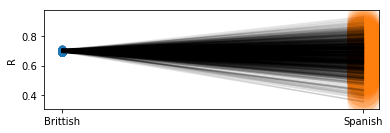

Variance 
 ceph       0.009313
spa        0.010285
average    0.004143
tus        0.011119
fin        0.014352
bri        0.000034
dtype: float64
mean 
 ceph       0.679220
spa        0.668863
average    0.678167
tus        0.664435
fin        0.678505
bri        0.699811
dtype: float64


In [367]:
df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation='bri')
print(len(df_temp))

# plotting the points
plt.scatter(np.zeros(len(df_temp)), df_temp.bri, s=50, alpha=0.1)
plt.scatter(np.ones(len(df_temp)), df_temp.spa, s=1000, alpha=0.05)

# plotting the lines
for index, row in df_temp.iterrows():
    plt.plot( [0,1], [row.bri, row.spa], c='k', alpha=0.1)

plt.xticks([0,1], ['Brittish', 'Spanish'])
plt.ylabel('R')
plt.show()
print("Variance \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].var())
print("mean \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].mean())

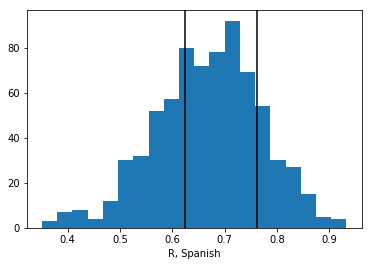

In [136]:
spanish_CI = get_conf_interval(initial_r, N=107*2)

plt.hist(df_temp.spa, bins=20)
plt.axvline(x=spanish_CI['lower'], c = 'k')
plt.axvline(x=spanish_CI['upper'], c = 'k')
plt.xlabel('R, Spanish')
plt.show()

In [137]:
print(spanish_CI)

{'upper': 0.76252911469958629, 'lower': 0.62451378613348041}


In [138]:
print('Percentage of SNP pairs inside CI')
print(sum((df_temp.spa > spanish_CI['lower']) & (df_temp.spa < spanish_CI['upper']) )/len(df_temp)*100)

Percentage of SNP pairs inside CI
50.7523939808


In [139]:
res = get_conf_interval_for_diff(df_temp.bri, df_temp.spa, n1=size_dict['bri']*2, n2=size_dict['spa']*2)
print(sum(res['lower']>0)/len(df_temp)*100)
print(sum(res['upper']<0)/len(df_temp)*100)
print(sum(res['lower']>0)/len(df_temp)*100 + sum(res['upper']<0)/len(df_temp)*100)

19.8358413133
11.0807113543
30.9165526676


In [140]:
def get_percentage_of_pairs_diff_is_significant(real_pop, ref_pop, initial_r, initial_margin=initial_margin):
    df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation=real_pop)
    res = get_conf_interval_for_diff(r1=df_temp[real_pop], r2=df_temp[ref_pop], 
                                     n1=size_dict[real_pop]*2, n2=size_dict[ref_pop]*2)
    return(sum(res['lower']>0)/len(df_temp)*100 + sum(res['upper']<0)/len(df_temp)*100)
    
    

In [141]:
get_percentage_of_pairs_diff_is_significant('bri', 'spa', 0.85,0.1)

50.044923629829285

In [144]:
delta_margin = get_margin_r_for_diff(initial_r, n1=size_dict['bri']*2, n2=size_dict['spa']*2, alpha=0.05)
print(delta_margin)
print(sum((df_temp.spa > delta_margin['r2_lower']) & (df_temp.spa < delta_margin['r2_upper']) )/len(df_temp.spa)*100)

{'r2_upper': 0.78978978978978975, 'r2_lower': 0.58438438438438434}
68.53625171


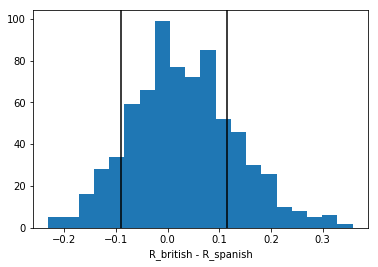

In [145]:
plt.hist(df_temp.bri - df_temp.spa , bins=20)
plt.xlabel('R_british - R_spanish')
plt.axvline(x=initial_r - delta_margin['r2_upper'], c = 'k')
plt.axvline(x=initial_r - delta_margin['r2_lower'], c = 'k')
plt.show()

# Delta-R from R


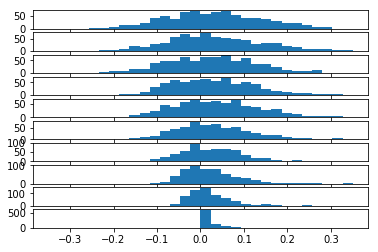

([0.59999999999999998,
  0.64444444444444438,
  0.68888888888888888,
  0.73333333333333328,
  0.77777777777777779,
  0.82222222222222219,
  0.8666666666666667,
  0.91111111111111109,
  0.95555555555555549,
  1.0],
 [0.012303934488295526,
  0.011546864425746312,
  0.010623257112931895,
  0.010098871468484098,
  0.0092472783202662365,
  0.007959826433812876,
  0.0057043999689190359,
  0.0041499369779657014,
  0.0023403715142518949,
  0.00067052242805887264])

In [103]:
def get_varr_r_lists(real_pop, ref_pop, initial_r=0.6, number_of_plots=10, plot_hist=False):
    r_array = []
    var_array = []
    for index, initial_r in enumerate(np.linspace(0.6,1,number_of_plots)):
        df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation=real_pop)
        delta_r = df_temp[real_pop] - df_temp[ref_pop]
        r_array.append(initial_r)
        var_array.append(delta_r.var())
        if plot_hist:    
            plt.subplot(number_of_plots, 1, index+1)
            plt.hist(delta_r, bins=30,  range=(-0.35, 0.35))
    if plot_hist:    
        plt.show()
    return r_array, var_array

get_varr_r_lists(real_pop = 'bri', ref_pop='spa', plot_hist=True)
    

In [113]:
df = pd.read_hdf('../LD_simul/results/r_0.75_0.85_0.95.h5')

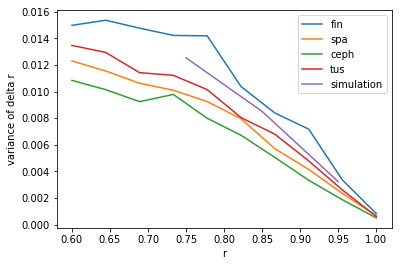

In [117]:
for nation in ['fin', 'spa', 'ceph', 'tus']:
    r_array, var_array = get_varr_r_lists(real_pop = 'bri', ref_pop=nation)
    plt.plot(r_array, var_array, label=nation)
    
plt.plot( df[df.gen == 300].groupby('r_0')['r'].var(), label = 'simulation' )

    
plt.xlabel('r')
plt.ylabel('variance of delta r')
plt.legend()
plt.show()    



##  Cojo info

In [256]:
cojo_df = pd.read_csv('first_type_error.tsv', sep = '\t')
cojo_df.head(2)
print(cojo_df.sim_r.unique())

[ 0.3  0.4  0.5  0.6  0.7]


In [242]:
def first_type_error_rate(sim_r):
    # delta_r = real - reference
    # delta_r < real + 1
    # delta_r > real - 1 
    fixed_sim_r_df = cojo_df[(cojo_df.sim_r == sim_r)]
    delta_r_array = cojo_df[(cojo_df.sim_r == sim_r) & 
                            (cojo_df.delta_r > sim_r - 1) & 
                            (cojo_df.delta_r < sim_r + 1)].delta_r.unique()
    fdr_list = []
    delta_r_list = []

    for delta_r in delta_r_array:
        temp_df = fixed_sim_r_df[(fixed_sim_r_df.delta_r == delta_r)]
        fdr = len(temp_df[temp_df.joint_p < 0.05])/len(temp_df)
        if len(temp_df) > 100:
            fdr_list.append(fdr)
            delta_r_list.append(delta_r)
            #print(len(temp_df), delta_r)
    return( pd.DataFrame({'delta_r': delta_r_list, 'fdr': fdr_list}))

In [249]:
def get_crical_values(sim_r):
    fdr_dynamics = first_type_error_rate(sim_r)
    min_r = sim_r - fdr_dynamics[fdr_dynamics.fdr < 0.10].delta_r.max()
    max_r = sim_r - fdr_dynamics[fdr_dynamics.fdr < 0.10].delta_r.min()
    return min_r, max_r

In [272]:
for i in cojo_df.sim_r.unique():
    lower, upper = get_crical_values(i)
    print(i, get_crical_values(i), i - upper, i - lower)

0.3 (-0.36666666666666653, 0.60303030303030325) -0.30303030303 0.666666666667
0.4 (-0.22626262626262605, 0.62222222222222234) -0.222222222222 0.626262626263
0.5 (-0.2474747474747474, 0.6818181818181821) -0.181818181818 0.747474747475
0.6 (-0.22828282828282831, 0.74141414141414141) -0.141414141414 0.828282828283
0.7 (-0.24949494949494944, 0.80101010101010117) -0.10101010101 0.949494949495


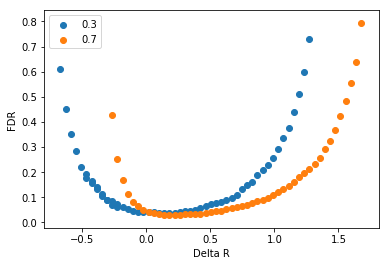

In [276]:
for i in [0.3, 0.7]:
    fdr_dynamics = first_type_error_rate(i)
    plt.scatter(fdr_dynamics.delta_r, fdr_dynamics.fdr, label = i)
plt.legend()
plt.xlabel('Delta R')
plt.ylabel('FDR')
plt.show()

In [368]:
def get_perc_of_pairs_above_cojo_threshold_expl_by_pop_diff(real_pop, ref_pop, initial_r, initial_margin=0.01):
    df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation=real_pop)
    lower, upper = get_crical_values(initial_r)
    z = np.arctanh(df_temp[ref_pop])
    z_limit = np.arctanh(upper)
    total_variance = z.var()
    var_by_real_pop_sample = 1/(size_dict[real_pop] - 3)
    var_by_ref_pop_sample = 1/(size_dict[ref_pop] - 3)
    var_by_pop_dif = total_variance - var_by_real_pop_sample - var_by_ref_pop_sample
    SE = np.sqrt(var_by_pop_dif)
    z_value = (z_limit - np.arctanh(initial_r))/SE
    p_value = norm.cdf(-z_value)
    return p_value
    
    
    
    

In [374]:
get_perc_of_pairs_above_cojo_threshold_expl_by_pop_diff(real_pop='bri', ref_pop='ceph', initial_r=0.7)

0.020171475150049425

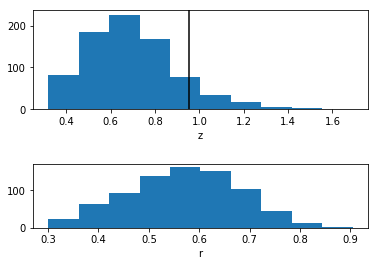

In [370]:
initial_r = 0.6
initial_margin = 0.01
df_temp = get_snp_pairs_in_range(lower_threshold=initial_r-initial_margin,
                                 upper_threshold=initial_r+initial_margin, 
                                 nation='bri')
lower, upper = get_crical_values(initial_r)

z = np.arctanh(df_temp.fin)
z_limit = np.arctanh(upper)

plt.subplot(2, 1, 1)
plt.hist(z) 
plt.xlabel('z')
plt.axvline(x=z_limit, c = 'k')
plt.subplot(3, 1, 3)
plt.hist(df_temp.spa)
plt.xlabel('r')
plt.show()


In [339]:
df_temp.fin[df_temp.fin==1]

132574    1.0
Name: fin, dtype: float64

In [297]:
z.var()

0.019136402548157089

In [299]:
1/(200)/z.var()

0.2612821290426669

# Stuff

In [22]:
df_eur['dist'] = abs(df_eur['BP_A'] - df_eur['BP_B'])

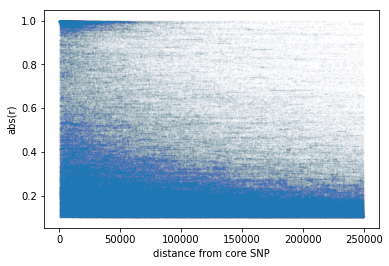

In [23]:
plt.scatter(df_eur['dist'], abs(df_eur['R']), alpha=0.01, s=0.7)
plt.xlabel("distance from core SNP")
plt.ylabel("abs(r)")
plt.show()

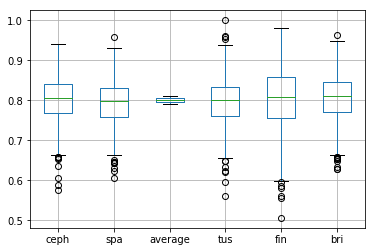

ceph       0.055579
spa        0.056676
average    0.005967
tus        0.058911
fin        0.077002
bri        0.055620
dtype: float64


In [24]:
df_08 = get_snp_pairs_in_range(lower_threshold=0.79, upper_threshold=0.81, nation='average')
abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

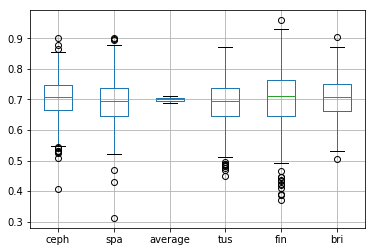

ceph       0.063009
spa        0.069311
average    0.005903
tus        0.069705
fin        0.091652
bri        0.066550
dtype: float64


In [25]:
df_07 = get_snp_pairs_in_range(lower_threshold=0.69, upper_threshold=0.71, nation='average')
abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

# Fisher Z-transformation

In [26]:
get_conf_interval(0.7, N=91*2)

{'lower': 0.61740827327609737, 'upper': 0.76732715371743243}

In [27]:
get_conf_interval(0.7, N=107*2)

{'lower': 0.62451378613348041, 'upper': 0.76252911469958629}

In [28]:
ci = get_conf_interval(0.8, N=100)
print(ci)
for name in df_dict.keys():
    print( name, len(df_08[(abs(df_08[name]) > ci["lower"]) & (abs(df_08[name]) < ci["upper"])])/len(df_08))

{'upper': 0.86110830048131048, 'lower': 0.71610699230849739}
fin 0.6404494382022472
tus 0.7865168539325843
bri 0.7849117174959872
ceph 0.812199036918138
spa 0.7913322632423756
